In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import datetime
import seaborn as sns

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sample_data
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [7]:
df = pd.read_csv("inflation interest unemployment.csv")

In [8]:
print('Shape of data', df.shape)
df.shape

Shape of data (13832, 13)


(13832, 13)

In [9]:
print(df.columns)

Index(['country', 'year', 'Inflation, consumer prices (annual %)',
       'Inflation, GDP deflator (annual %)', 'Real interest rate (%)',
       'Deposit interest rate (%)', 'Lending interest rate (%)',
       'Unemployment, total (% of total labor force) (national estimate)',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)',
       'iso3c', 'iso2c', 'adminregion', 'incomeLevel'],
      dtype='object')


In [10]:
#Delete columns that are not needed
columns_to_delete = ['iso3c', 'iso2c', 'country', 'adminregion', 'incomeLevel', 'Lending interest rate (%)', 'Unemployment, total (% of total labor force) (national estimate)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)']
df.drop(columns=columns_to_delete, inplace=True)

In [11]:
print(df.columns)

Index(['year', 'Inflation, consumer prices (annual %)',
       'Inflation, GDP deflator (annual %)', 'Real interest rate (%)',
       'Deposit interest rate (%)'],
      dtype='object')


In [12]:

# Check for NaN values in the exogenous variables
nan_col= df.columns[df.isna().any()].tolist()

# Drop rows with NaN values in exogenous variables
df1 = df.dropna(subset=nan_col)

# Now you can proceed with your analysis

In [13]:
print(df1)

       year  Inflation, consumer prices (annual %)  \
178    1992                             226.005421   
179    1993                              85.004751   
180    1994                              22.565053   
181    1995                               7.793219   
182    1996                              12.725478   
...     ...                                    ...   
13826  2016                              -1.543670   
13827  2017                               0.893962   
13828  2018                              10.618866   
13829  2019                             255.304991   
13830  2020                             557.201817   

       Inflation, GDP deflator (annual %)  Real interest rate (%)  \
178                            232.984659              -63.787120   
179                            125.650814              -42.573514   
180                             35.842475               -8.963182   
181                              9.970663                8.801745   
182   

In [14]:
#Rename to simply Inflation
df2 = df.rename(columns={"Inflation, consumer prices (annual %)": "Inflation"})

In [15]:
# Replace 'NaN' values with 0
df2.fillna(0, inplace=True)

In [16]:
print(df2)

       year   Inflation  Inflation, GDP deflator (annual %)  \
0      1970    0.000000                            0.000000   
1      1971    0.000000                            0.000000   
2      1972    0.000000                            0.000000   
3      1973    0.000000                            0.000000   
4      1974    0.000000                            0.000000   
...     ...         ...                                 ...   
13827  2017    0.893962                            2.437608   
13828  2018   10.618866                           59.803356   
13829  2019  255.304991                          440.829791   
13830  2020  557.201817                          558.560024   
13831  2021    0.000000                            0.000000   

       Real interest rate (%)  Deposit interest rate (%)  
0                    0.000000                   0.000000  
1                    0.000000                   0.000000  
2                    0.000000                   0.000000  
3      

In [17]:
#Check if all the coulmns are stattionary for use
for i in range(len(df2.columns)):
  result = adfuller(df2[df2.columns[i]])

  if result[1] > 0.05:
    print('{} - Series is not stationary'.format(df2.columns[i]))
  else:
    print('{} - Series is stationary'.format(df2.columns[i]))

year - Series is stationary
Inflation - Series is stationary
Inflation, GDP deflator (annual %) - Series is stationary
Real interest rate (%) - Series is stationary
Deposit interest rate (%) - Series is stationary


In [18]:
df2.tail(3)

,year,Inflation,"Inflation, GDP deflator (annual %)",Real interest rate (%),Deposit interest rate (%)
13829,2019,255.304991,440.829791,-78.517887,2.975000
13830,2020,557.201817,558.560024,-79.803157,4.518333
13831,2021,0.000000,0.000000,0.000000,8.059167


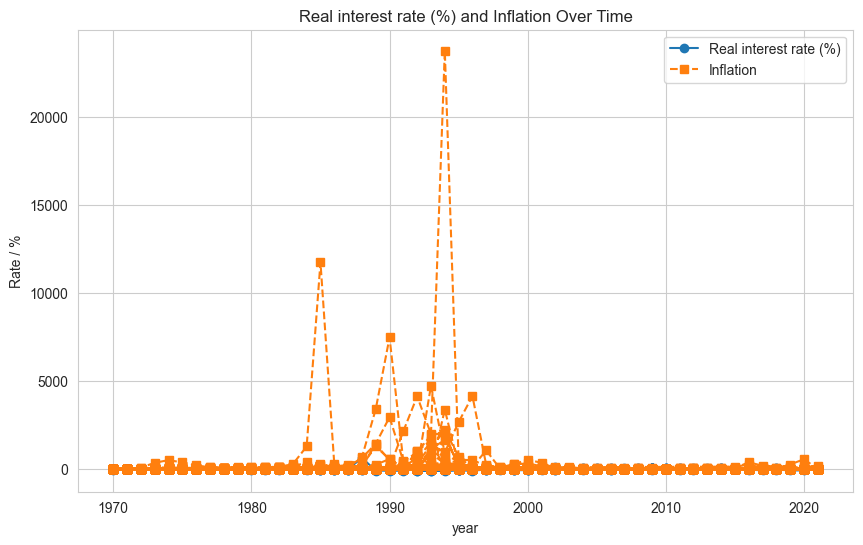

In [19]:
year = df2['year']
interest_rate = df2['Real interest rate (%)']
inflation = df2['Inflation']

# Create a line plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(year, interest_rate, label='Real interest rate (%)', marker='o', linestyle='-')
plt.plot(year, inflation, label='Inflation', marker='s', linestyle='--')

# Add labels and a title
plt.xlabel('year')
plt.ylabel('Rate / %')
plt.title('Real interest rate (%) and Inflation Over Time')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)  # Add grid lines
plt.show()

<AxesSubplot: xlabel='Real interest rate (%)', ylabel='Inflation'>

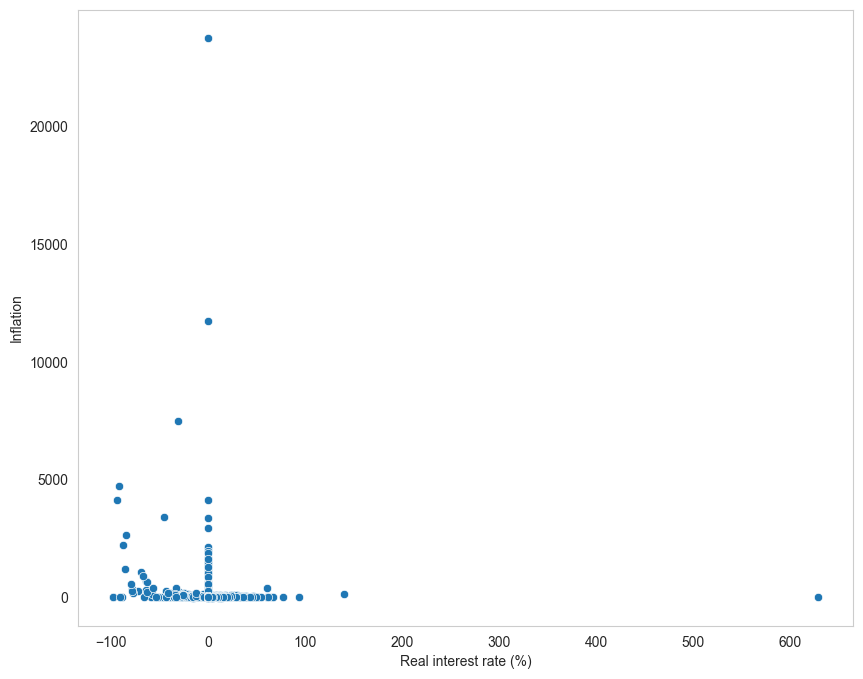

In [20]:
# visualizes the relationship between two variables
sns.scatterplot(data=df2, x="Real interest rate (%)", y="Inflation")

In [21]:
 #Create a VAR model
model = VAR(df2)

In [22]:
#Determine the lag order using an information criterion (e.g., AIC)
best_lag = model.select_order(maxlags=12)

In [23]:
selected_lag_order = best_lag.aic

# Fit the VAR model with the selected lag order
var_model = model.fit(selected_lag_order)

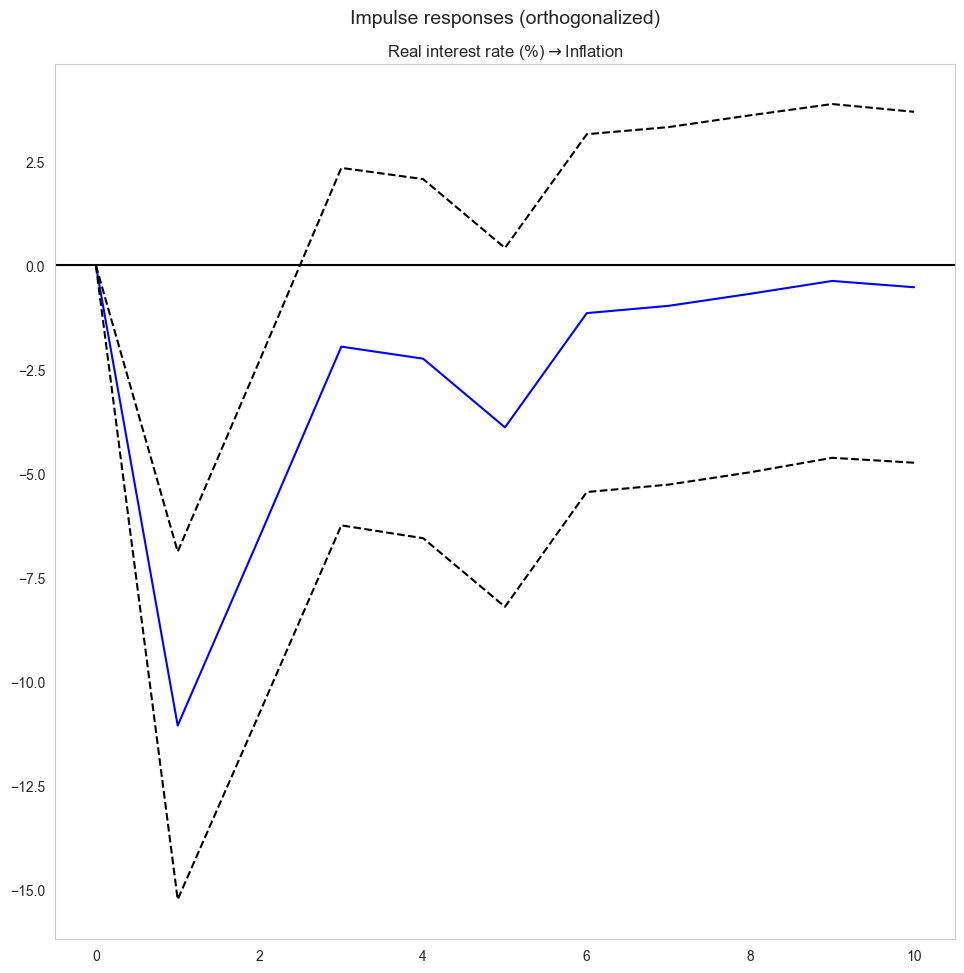

In [24]:
#visualize the impulse response of "Inflation" to a shock in the "Real interest rate (%)" within the context of a VAR model
irf = var_model.irf()
irf.plot(impulse='Real interest rate (%)', response='Inflation', orth=True)
plt.show()

In [25]:

# Forecast for n periods ahead using the selected lag order
n_forecast = 12  # Change this to your desired forecast horizon
forecast = var_model.forecast(df2.values[-selected_lag_order:], steps=n_forecast)
forecast_df = pd.DataFrame(forecast, columns=df2.columns)

In [26]:
year = df2['year']
Inflation_df = df2['Inflation']
df_Real_interest_rate = df2['Real interest rate (%)']

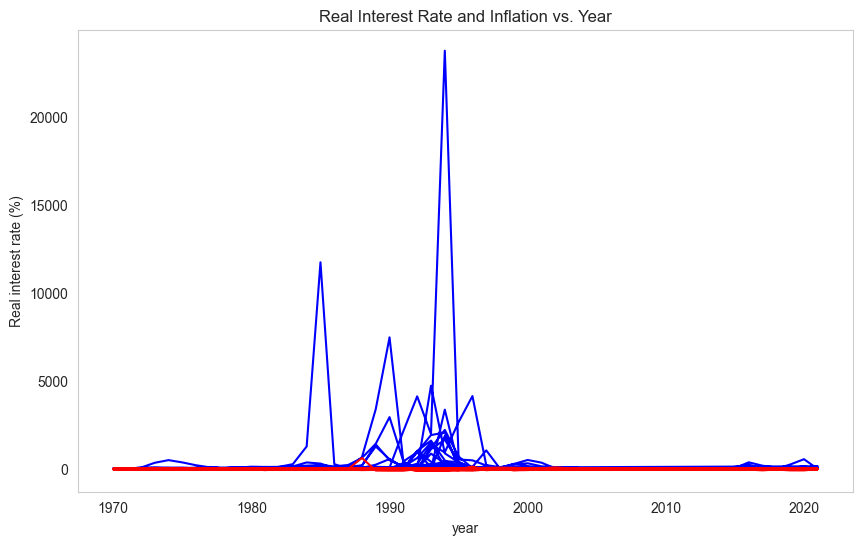

In [27]:
plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
plt.title("Real Interest Rate and Inflation vs. Year")
plt.xlabel("year")
plt.ylabel("Real interest rate (%)")
plt.plot(year,Inflation_df , label="Inflation", color='blue')
plt.plot(year,df_Real_interest_rate , label="Real interest rate (%)", color='red')

In [28]:
actual_data = df2[-12:]

In [29]:
year = df2['year']
Inflation_GDP_df = df2['Inflation, GDP deflator (annual %)']
df_Deposit_interest_rate = df2['Deposit interest rate (%)']

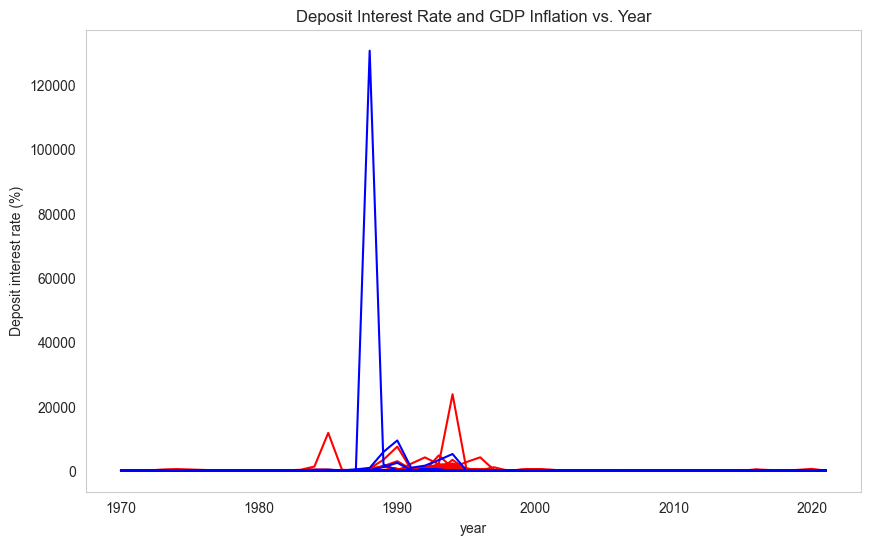

In [30]:
plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
plt.title("Deposit Interest Rate and GDP Inflation vs. Year")
plt.xlabel("year")
plt.ylabel("Deposit interest rate (%)")
plt.plot(year,Inflation_df , label="Inflation, GDP deflator (annual %)", color='red')
plt.plot(year,df_Deposit_interest_rate , label="Deposit interest rate (%)", color='blue')

In [31]:
#evaluating the accuracy of a forecasting model
mae = mean_absolute_error(actual_data, forecast_df)
mse = mean_squared_error(actual_data, forecast_df)
rmse = math.sqrt(mse)
print("mean_absolute_error:", mae)
print('mean_squared_error:',mse)
print('math.sqrt:',rmse)


mean_absolute_error: 50.07182650645854
mean_squared_error: 15403.448971775884
math.sqrt: 124.11063198524083


In [32]:
if len(actual_data) < len(forecast_df):
    forecast_df = forecast_df.reindex(range(len(actual_data)))

In [33]:
# Calculate Mean Absolute Error (MAE)

mae = mean_absolute_error(df2, forecast_df)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_data, forecast_data)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

ValueError: Found input variables with inconsistent numbers of samples: [13832, 12]